<a href="https://colab.research.google.com/github/ZacCarrico/basic_transformer/blob/main/decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The goal of this is to train a simple attention-based decoder model using DNA as the input data. The hypothesis is that this model will generate a new DNA sequence with similar codon frequencies to the input DNA.

# Background
like those used in [Attention is All You Need](https://arxiv.org/abs/1706.03762). This code is a derivative of [Andrej Karpathy's decoder training code](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py[link text)

In [37]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

with open('human_type1_collagen_protein_encoding.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
decoded = decode(m.generate(context, max_new_tokens=5000)[0].tolist())
open('generated_dna.txt', 'w').write(decoded)

10.646788 M parameters
step 0: train loss 1.3830, val loss 1.4116
step 500: train loss 1.1361, val loss 1.4802
step 999: train loss 1.1192, val loss 1.4472


5001

In [20]:
def codon_frequency(dna):
  """Calculates the frequency of each codon in a DNA sequence.

  Args:
    dna: A string representing the DNA sequence.

  Returns:
    A dictionary mapping codons to their frequencies.
  """

  codon_counts = {}
  for i in range(0, len(dna), 3):
    codon = dna[i:i + 3]
    codon_counts[codon] = codon_counts.get(codon, 0) + 1

  codon_frequencies = {}
  for codon, count in codon_counts.items():
    codon_frequencies[codon] = count / len(dna)

  return codon_frequencies

In [61]:
with open('generated_dna.txt', 'r') as f:
    decoded = f.readlines()[0]
with open('human_type1_collagen_protein_encoding.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [63]:
input_codon_frequencies = codon_frequency(text)
generated_codon_frequencies = codon_frequency(decoded)
print(f"{len(input_codon_frequencies)=}")
print(f"{len(generated_codon_frequencies)=}")
print(set(generated_codon_frequencies.keys()) - set(input_codon_frequencies.keys()))

len(input_codon_frequencies)=58
len(generated_codon_frequencies)=64
{'tcg', 'ccg', 'tag', 'taa', 'tga', 'cta'}


In [39]:
all_codons = []
for permutation in itertools.product('atgc', repeat=3):
    all_codons.append(''.join(permutation))

assert len(all_codons) == 64
def add_missing_codons(codons):
    for codon in all_codons:
        if codon not in codons:
            codons[codon] = 0
    return codons

input_codon_frequencies = add_missing_codons(input_codon_frequencies)
generated_codon_frequencies = add_missing_codons(generated_codon_frequencies)
print(f"{len(input_codon_frequencies)=}")
print(f"{len(generated_codon_frequencies)=}")

len(input_codon_frequencies)=64
len(generated_codon_frequencies)=64


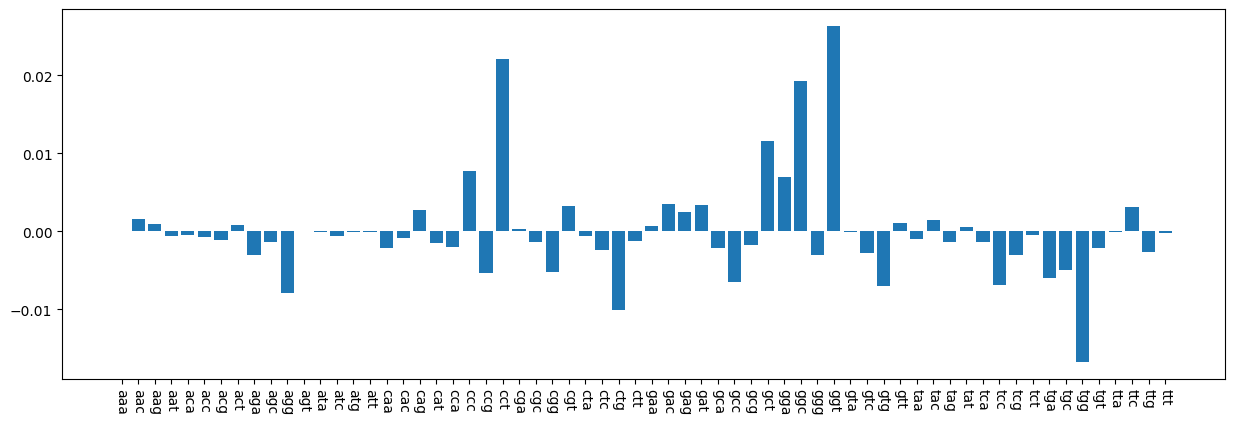

In [54]:
# sorted by key, return a list of tuples
input_freq = sorted(input_codon_frequencies.items())
gen_freq = sorted(generated_codon_frequencies.items())
all_codons.sort()

# unpack a list of pairs into two tuples
input_freq_codon, input_freq_vals = zip(*input_freq)
gen_freq_codon, gen_freq_vals = zip(*gen_freq)

diff = []
for i in range(len(input_freq_codon)):
    diff.append(input_freq_vals[i] - gen_freq_vals[i])


plt.figure().set_figwidth(15)
plt.bar(all_codons, diff)
plt.xticks(rotation=-90)
plt.show()

The above plot shows the difference in codon frequency between the generated and input sequences. There is a tendency for specific codons in the real (input) DNA to be used to a greater frequency, and for the generated DNA to be uniform in its codons. This preference for specific codons was missed my the model for several codons.

When doing a Blast search, the generated DNA doesn't match any known human DNA (not even collagen, the input DNA sequence).